# Providing custom stimuli

Follow this notebook to learn how to use our models for generating hypothesis about neural computations with custom stimuli.

## Example dataset

We take the public [Moving MNIST](https://www.cs.toronto.edu/~nitish/unsupervised_video/) sequence dataset as an example for a custom stimulus dataset.
Moving MNIST consists of short grey-scale videos of numbers from 1-10 which move in arbitrary directions. The dataset entails 10,000 sequences of 20 frames each. Individual frames are 64x64 pixels in height and width.

In [1]:
import os

from typing import List
from tqdm import tqdm
import torch
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

import flyvision
from flyvision.datasets.base import SequenceDataset

/home/eudald/Desktop/doctorat/flyvis/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Get npy array of sequences from video directory
video_root_path = os.path.join("..", "videos")
blue_path = os.path.join(video_root_path, "blue")
yellow_path = os.path.join(video_root_path, "yellow")
blue_videos = [np.load(os.path.join(blue_path, a)) for a in os.listdir(blue_path)]
# yellow_seq = np.load(os.path.join("..", "videos", "yellow"))

In [2]:
def load_custom_sequences(video_dir):
    videos = [np.load(os.path.join(video_dir, a)) for a in os.listdir(video_dir)]
    # Take the average of the 3 color channels to get a single greyscale channel
    # Create an array with the proper dimensions (n_sequences, n_frames, height, width)
    return np.array([np.mean(a, axis=3) for a in videos])

## BoxEye rendering

##### Rendering cartesian images to hexagonal lattice

We translate cartesian frames into receptor activations by placing simulated photoreceptors in a two-dimensional hexagonal array in pixel space (blue dots below), 31 columns across resulting in 721 columns in total, spaced 13 pixels apart. The transduced luminance at each photoreceptor is the greyscale mean value in the 13×13-pixel region surrounding it (black boxes).

### Render a single frame

To illustrate, this is what rendering a single frame looks like.

## Render a whole dataset to disk

We save rendered sequences to disk to retrieve them faster at runtime.

We will use our library datamate here because it provides a powerful interface for writing and reading arrayfiles.

In [5]:
import os
# the Directory class is a smart pointer to a specific directory
# on the filesystem

# directory to store the rendered custom stimuli
rendered_data_dest = flyvision.root_dir

class RenderedData():

    def __init__(self, config: dict):
        
        # here comes the preprocessing and rendering as above or similar -- depending on the dataset etc.
        # this code will be executed automatically once for each unique configuration to store preprocessed
        # data on disk and later simply provide a reference to it.
        sequences = load_custom_sequences("../videos/blue")

        # we use the configuration to control the settings under which we render the stimuli
        receptors = flyvision.rendering.BoxEye(
            extent=config.get("extent"), kernel_size=config.get("kernel_size")
        )

        # for memory-friendly rendering we can loop over individual sequences
        # and subsets of the dataset
        rendered_sequences = []
        subset_idx = getattr(config, "subset_idx", []) or list(
            range(sequences.shape[0])
        )
        with tqdm(total=len(subset_idx)) as pbar:
            for index in subset_idx:
                rendered_sequences.append(receptors(sequences[[index]]).cpu().numpy())
                pbar.update()

        # to join individual sequences along their first dimension
        # to obtain (n_sequences, n_frames, 1, receptors.hexals)
        rendered_sequences = np.concatenate(rendered_sequences, axis=0)

        # the __setattr__ method of the Directory class saves sequences to self.path/"sequences.h5"
        # that can be later retrieved using self.sequences[:]
        self.sequences = rendered_sequences

In [6]:
# note, to render the whole dataset provide an empty list for `subset_idx` or delete the key word argument 
moving_custom_rendered = RenderedData(dict({"extent": 15, "kernel_size": 13, "subset_idx": [0, 1, 2, 3]}))

KeyboardInterrupt: 

In [6]:
# this is how we can retrieve the sequences from the disk into memory
rendered_sequences = moving_custom_rendered.sequences[:]

In [7]:
rendered_sequences.shape

(100, 20, 1, 721)

In [10]:
animation = flyvision.animations.HexScatter(rendered_sequences, vmin=0, vmax=256)
# animation.animate_in_notebook()

In [29]:
# Note, to delete a Directory, e.g. to change the __init__ and reinstantiate,
# run moving_mnist_rendered.rmtree("y").

## Create a sequence dataset

Next we create a Pytorch dataset for loading the sequences.

In [7]:
class CustomStimuli(SequenceDataset):
    
    # implementing the SequenceDataset interface 
    dt = 1/100
    framerate = 24
    t_pre = 0.5
    t_post = 0.5
    n_sequences = None
    augment = False
    
    def __init__(self, rendered_data_config: dict):
        self.dir = RenderedData(rendered_data_config)
        self.sequences = torch.Tensor(self.dir.sequences[:])
        self.n_sequences = self.sequences.shape[0]

    def get_item(self, key):
        sequence = self.sequences[key]
        # to match the framerate to the integration time dt, we can resample frames
        # from these indices. note, when dt = 1/framerate, this will return the exact sequence
        resample = self.get_temporal_sample_indices(sequence.shape[0], sequence.shape[0])
        return sequence[resample]

In [14]:
# note, to render the whole dataset provide an empty list for `subset_idx` or delete the key word argument 
data = CustomStimuli(dict(extent=15, kernel_size=13))

100%|██████████| 100/100 [00:12<00:00,  7.95it/s]


In [15]:
data[0].shape

torch.Size([84, 1, 721])

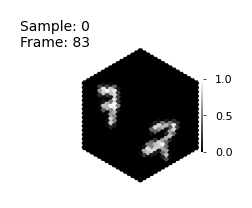

In [6]:
animation = flyvision.animations.HexScatter(data[0][None], vmin=0, vmax=1)
# animation.animate_in_notebook()

## Compute model responses to custom stimuli

Now, we can compute model responses across individual models or the whole ensemble to our custom stimulus.

##### Select a pretrained network

To select a network from the ensemble of 50 pretrained networks, let's see what our options are.

Paths to pretrained models from the ensemble end with four digit numbers which are sorted by task error (0-49 from best to worst).

In [16]:
sorted(
    [
        p.relative_to(flyvision.results_dir)
        for p in (flyvision.results_dir / "opticflow/000").iterdir()
        if p.name.isnumeric()
    ]
)

[PosixPath('opticflow/000/0000'),
 PosixPath('opticflow/000/0001'),
 PosixPath('opticflow/000/0002'),
 PosixPath('opticflow/000/0003'),
 PosixPath('opticflow/000/0004'),
 PosixPath('opticflow/000/0005'),
 PosixPath('opticflow/000/0006'),
 PosixPath('opticflow/000/0007'),
 PosixPath('opticflow/000/0008'),
 PosixPath('opticflow/000/0009'),
 PosixPath('opticflow/000/0010'),
 PosixPath('opticflow/000/0011'),
 PosixPath('opticflow/000/0012'),
 PosixPath('opticflow/000/0013'),
 PosixPath('opticflow/000/0014'),
 PosixPath('opticflow/000/0015'),
 PosixPath('opticflow/000/0016'),
 PosixPath('opticflow/000/0017'),
 PosixPath('opticflow/000/0018'),
 PosixPath('opticflow/000/0019'),
 PosixPath('opticflow/000/0020'),
 PosixPath('opticflow/000/0021'),
 PosixPath('opticflow/000/0022'),
 PosixPath('opticflow/000/0023'),
 PosixPath('opticflow/000/0024'),
 PosixPath('opticflow/000/0025'),
 PosixPath('opticflow/000/0026'),
 PosixPath('opticflow/000/0027'),
 PosixPath('opticflow/000/0028'),
 PosixPath('op

We use the `NetworkView` class to point to a model. This object can implement plots plus methods to initialize network, stimuli etc. 

In [10]:
network_view = flyvision.network.NetworkView(flyvision.results_dir / "opticflow/000/0000")

In [11]:
# to load the Pytorch module with pretrained parameters
network = network_view.init_network(chkpt="best_chkpt")

In [17]:
movie_input = data[0]

In [18]:
movie_input.shape

torch.Size([84, 1, 721])

##### Compute a stationary state

We initialize the network at a stationary state, to remove transient responses due to stimulus onset from functional stimulus responses like motion detection. The network provides two methods for stationary state computation `network.fade_in_state` and `network.steady_state`. We use `fade_in_state` here, which slowly ramps up
the intensity of the first frame in the sequence to compute a stationary state that minimizes the transient response. The method `steady_state` computes a sequence-independent stationary state by providing a whole-field grey-scale stimulus at medium intensity (but it does not get rid of a transient response).

In [26]:
stationary_state = network.fade_in_state(1.0, data.dt, movie_input[[0]])

##### Obtain network responses

A convenient way to obtain network responses is to call `network.simulate`
which calls the forward function of the Pytorch module without tracking gradients
(plus it provides a simpler interface than `network.forward` because it already maps stimulus to receptors using the `network.stimulus` attribute).

In [27]:
# For analysis, we move the returned tensor to cpu.
responses = network.simulate(movie_input[None], data.dt, initial_state=stationary_state).cpu()

In [28]:
responses.shape

torch.Size([1, 84, 45669])

##### Visualize responses of specific cells

In [29]:
from flyvision.utils.activity_utils import LayerActivity
from flyvision.animations import StimulusResponse

`LayerActivity` is an interface to the response tensor of 45k cells that allows dict- and attribute-style access to the responses of individual cell types and to the responses of their central cells.

In [30]:
responses = LayerActivity(responses, network.connectome, keepref=True)

In [31]:
responses

Activity of: 
R1, R2, R3, R4, R5, R6, R7, R8, L1, L2, L3, L4, L5, Lawf1, Lawf2, Am,
C2, C3, CT1(Lo1), CT1(M10), Mi1, Mi2, Mi3, Mi4, Mi9, Mi10, Mi11, Mi12,
Mi13, Mi14, Mi15, T1, T2, T2a, T3, T4a, T4b, T4c, T4d, T5a, T5b, T5c,
T5d, Tm1, Tm2, Tm3, Tm4, Tm5Y, Tm5a, Tm5b, Tm5c, Tm9, Tm16, Tm20,
Tm28, Tm30, TmY3, TmY4, TmY5a, TmY9, TmY10, TmY13, TmY14, TmY15, TmY18

In [32]:
cell_type = "TmY18"

The stimulus on the left, and the response on the right described by passive point neuron voltage dynamics. Cells depolarize (red) and hyperpolarize (blue) in response to the stimulus. A single "hexal" corresponds to one neuron of the cell type.

KeyboardInterrupt: 

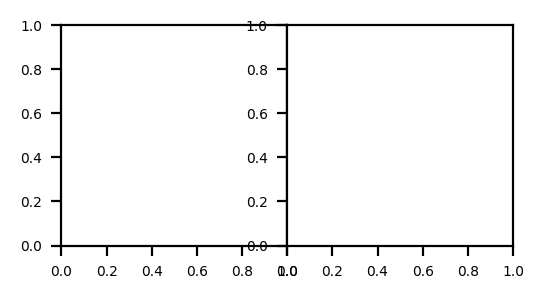

In [50]:
anim = StimulusResponse(
    movie_input[None],
    responses[cell_type][:, :, None]
)
anim.animate_in_notebook(frames=np.arange(anim.frames)[::2])

In [44]:
np.array(anim.responses).shape

(1, 1, 84, 1, 721)

In [47]:
responses.activity.shape

torch.Size([1, 84, 45669])


Often, we are interested in a canonical response of a specific cell type to a specific stimulus to generate hypotheses for their role in a computation. In our model, we can take the central cell as a proxy for all cells of the given type, because cells share their parameters and in- and output connections. I.e. the responses of all cells of a given type would be the same (not taking boundary effects into account) when the same stimulus would cross their identical but spatially offset receptive field in the same way.

In [34]:
n_frames = movie_input.shape[0]
time = np.arange(0, n_frames * data.dt, data.dt)

Text(0, 0.5, 'central response (a.u.)')

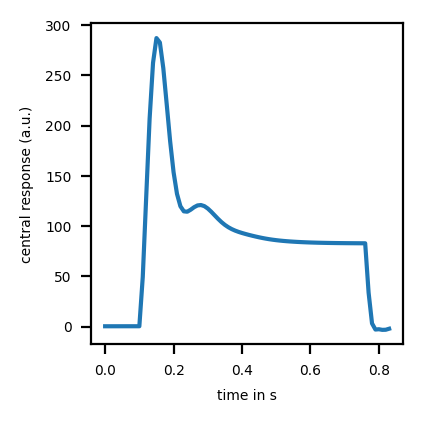

In [35]:
fig, ax = flyvision.plots.plt_utils.init_plot([2, 2], fontsize=5)
ax.plot(time, responses.central[cell_type].squeeze())
ax.set_xlabel("time in s", fontsize=5)
ax.set_ylabel("central response (a.u.)", fontsize=5)

## Compute responses over the whole ensemble

In addition to looking at individual models, we next compute responses across the whole ensemble at once to look at them jointly.

In [19]:
from typing import List
from tqdm import tqdm
import torch
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

from datamate import root, Directory

import flyvision

from flyvision.datasets.base import SequenceDataset
from flyvision.utils.activity_utils import LayerActivity
from flyvision.animations import StimulusResponse
from flyvision.ensemble import EnsembleView

In [20]:
class RenderedData:
    class Config(dict):
        input_path: str  # path to the input data
        extent: int  # radius, in number of receptors of the hexagonal array.
        kernel_size: int  # photon collection radius, in pixels.
        subset_idx: List[int]  # if specified, subset of sequences to render

    def __init__(self, config: Config):
        # here comes the preprocessing and rendering as above or similar -- depending on the dataset etc.
        # this code will be executed automatically once for each unique configuration to store preprocessed
        # data on disk and later simply provide a reference to it.
        sequences = load_custom_sequences(config["input_path"])

        # we use the configuration to control the settings under which we render the stimuli
        receptors = flyvision.rendering.BoxEye(
            extent=config["extent"], kernel_size=config["kernel_size"]
        )

        # for memory-friendly rendering we can loop over individual sequences
        # and subsets of the dataset
        rendered_sequences = []
        subset_idx = getattr(config, "subset_idx", []) or list(
            range(sequences.shape[0])
        )
        with tqdm(total=len(subset_idx)) as pbar:
            for index in subset_idx:
                rendered_sequences.append(receptors(sequences[[index]]).cpu().numpy())
                pbar.update()

        # to join individual sequences along their first dimension
        # to obtain (n_sequences, n_frames, 1, receptors.hexals)
        rendered_sequences = np.concatenate(rendered_sequences, axis=0)

        # the __setattr__ method of the Directory class saves sequences to self.path/"sequences.h5"
        # that can be later retrieved using self.sequences[:]
        self.sequences = rendered_sequences

In [21]:
class CustomStimuli(SequenceDataset):
    
    # implementing the SequenceDataset interface 
    dt = 1/100
    framerate = 24
    t_pre = 0.5
    t_post = 0.5
    n_sequences = None
    augment = False
    
    def __init__(self, rendered_data_config: dict):
        self.dir = RenderedData(rendered_data_config)
        self.sequences = torch.Tensor(self.dir.sequences[:])
        self.n_sequences = self.sequences.shape[0]

    def get_item(self, key):
        sequence = self.sequences[key]
        # to match the framerate to the integration time dt, we can resample frames
        # from these indices. note, when dt = 1/framerate, this will return the exact sequence
        resample = self.get_temporal_sample_indices(sequence.shape[0], sequence.shape[0])
        return sequence[resample]

In [22]:
# note, to render the whole dataset provide an empty list for `subset_idx` or delete the key word argument 
data = CustomStimuli(dict(input_path="../videos/yellow", extent=15, kernel_size=13, subset_idx=[]))

100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


##### Select the pretrained ensemble

Similar to the `NetworkView` object, the `EnsembleView` object points to an ensemble and implements plots plus methods to initialize networks, stimuli etc. This object provides dict- and attribute-style access to individual `NetworkView` instances.

In [9]:
ensemble = EnsembleView(flyvision.results_dir / "opticflow/000")

##### Simulate responses for each network

In [10]:
movie_input = data[0]

In [1]:
movie_input.shape

NameError: name 'movie_input' is not defined

`ensemble.simulate` provides an efficient method to return responses of all networks within the ensemble.

In [11]:
# ensemble.simulate returns an iterator over `network.simulate` for each network.
# we exhaust it and stack responses from all models in the first dimension
responses = np.array(list(ensemble.simulate(movie_input[None], data.dt, fade_in=True)))

In [12]:
# dims are (n_models, n_sequences, n_frames, n_cells)
responses.shape

(50, 1, 84, 45669)

In [13]:
np.save("../parsed_objects/responses_yellow.npy", responses)